In [1]:
import numpy as np
import pytpc
from pytpc.fitting.mcopt_wrapper import Tracker, EventGenerator, PadPlane, Minimizer
from pytpc.fitting.montecarlo import MCFitter
from pytpc.constants import *
from pytpc.cleaning import HoughCleaner
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import yaml
import math
from effsim.paramgen import uniform_param_generator
from effsim.effsim import EventSimulator
from scipy import interpolate

/home/chen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
with open('/home/chen/ar40/config/config_e15503a_runs_92-104.yml', 'r') as f:
    config = yaml.load(f)

mcfitter = MCFitter(config)

In [3]:
tilt = config['tilt'] * degrees 
padplane = mcfitter.padplane
efield = np.array(config['efield'])
bfield = np.array(config['bfield'])
mass_num = config['mass_num']
charge_num = config['charge_num']
gas = pytpc.gases.InterpolatedGas(config['gas_name'], config['gas_pressure'])
beam_enu0 = config['beam_enu0']
beam_charge = config['beam_charge']
beam_mass = config['beam_mass']
max_en = config['tracker_max_en']
vd = np.array(config['vd'])
max_beam_angle = (config['max_beam_angle']*math.pi)/180
beam_origin_z = config['beam_origin_z']
num_iters = config['num_iters']
num_pts = config['num_pts']
red_factor = config['red_factor']
clock = config['clock']
shape = config['shape']
pad_rot_angle = (config['pad_rot_angle']*math.pi)/180
electronics_gain = float(config['electronics_gain'])
micromegas_gain = float(config['micromegas_gain'])
diff_sigma = config['diffusion_sigma']
ioniz = 23.0 #eV

In [4]:
#Good events for run_0102 are: 689, 765, 896, 305, 504, 575, 456, 299, 399, 156, 231, 7832, 1568, 1354, 789, 485, 2456, 357, 4568, 1448, 3578, 745, 430, 1676, 811, 641, 871, 785, 37, 24, 75, 72, 35, 16, 12, 1718, 1, 9
full = h5py.File('/home/chen/ar40/config/clean_run_0102.h5', 'r')
evt_ID = 305
dataset_name = '/clean'
evt_full = full[dataset_name]
xyzs_h5 = evt_full[str(evt_ID)]
xyzs = np.array(xyzs_h5)

#delete the points which are farther away from the center of the spiral
del_list = []

DRIFT_VEL = 5.2
CLOCK = 12.5

for i in range(len(xyzs)):
    if (xyzs[i,6]) > 40.0:
        del_list.append(i)
    elif (xyzs[i][2])*CLOCK/DRIFT_VEL > 500.0:
        del_list.append(i)
    elif (xyzs[i][5] < 2.0): 
        del_list.append(i)         

cut_xyzs = np.delete(xyzs,del_list,axis=0)

print(xyzs[0])

[-1.45741499e+02  9.06868891e-01  1.86516085e+02  5.14131784e+02
  9.18200000e+03  4.00000000e+00  1.47813910e+01]


In [5]:
######finding center of curvature#######
xy = xyzs[:, 0:2]
xy_C = np.ascontiguousarray(xy, dtype=np.double)
cx, cy = pytpc.cleaning.hough_circle(xy_C)
print(cx,cy) #The center of curvature of the track, in mm.

cut_xy = cut_xyzs[:, 0:2]
cut_xy_C = np.ascontiguousarray(cut_xy, dtype=np.double)
cut_cx, cut_cy = pytpc.cleaning.hough_circle(cut_xy_C)

-43.91625428724363 9.816445862844423


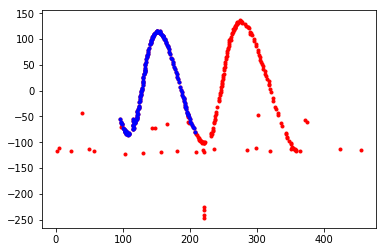

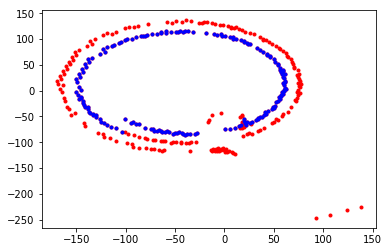

In [6]:
#######plotting real event#########
%matplotlib inline
plt.plot(xyzs[:, 2], xyzs[:, 1], 'r.')
plt.plot(cut_xyzs[:, 2], cut_xyzs[:, 1], 'b.')
plt.show()
plt.plot(xyzs[:, 0], xyzs[:, 1], 'r.')
plt.plot(cut_xyzs[:, 0], cut_xyzs[:, 1], 'b.')
plt.show()

In [7]:
uvw, (cu, cv) = mcfitter.preprocess(xyzs[:,0:5], center=(cx, cy), rotate_pads=False)
uvw_sorted = uvw.sort_values(by='w', ascending=True)
prefit_data = uvw_sorted.iloc[-len(uvw_sorted) // 4:].copy()
prefit_res = mcfitter.linear_prefit(prefit_data, cu, cv)
ctr0 = mcfitter.guess_parameters(prefit_res)
exp_pos = uvw_sorted[['u', 'v', 'w']].values.copy() / 1000
ctr0[4] += 2*pi
print(ctr0)

cut_uvw, (cut_cu, cut_cv) = mcfitter.preprocess(cut_xyzs[:,0:5], center=(cut_cx, cut_cy), rotate_pads=False)
cut_uvw_sorted = cut_uvw.sort_values(by='w', ascending=True)
cut_prefit_data = cut_uvw_sorted.iloc[-len(cut_uvw_sorted) // 4:].copy()
cut_prefit_res = mcfitter.linear_prefit(cut_prefit_data, cut_cu, cut_cv)
cut_ctr0 = mcfitter.guess_parameters(cut_prefit_res)
cut_exp_pos = cut_uvw_sorted[['u', 'v', 'w']].values.copy() / 1000
print(cut_ctr0)

[0.         0.         0.64505462 2.12373241 3.49679364 1.90405046]
[ 0.          0.          0.36338824  1.50750185 -2.7894479   1.90515488]


In [8]:
exp_hits = np.zeros(10240)
for a, p in uvw[['a', 'pad']].values:
    exp_hits[int(p)] = a
    
cut_exp_hits = np.zeros(10240)
for a, p in cut_uvw[['a', 'pad']].values:
    cut_exp_hits[int(p)] = a

In [12]:
####### generate a set of parameter vectors within given range #########
sig = config['sigma']
sigma = np.array([sig['x'],sig['y'],sig['z'],sig['enu'],sig['azi']*math.pi/180,sig['pol']*math.pi/180])

num_events = 15000
candidates = [sigma]
pgen = uniform_param_generator(beam_enu0, beam_mass, beam_charge, mass_num, max_beam_angle,\
                               beam_origin_z, gas, num_events)

for evt in pgen:
    p = evt[0]
    try:
        if abs(p[0]-ctr0[0]) >= sigma[0]:
            raise ValueError
        elif abs(p[1]-ctr0[1]) >= sigma[1]:
            raise ValueError
        elif abs(p[2]-ctr0[2]) >= sigma[2]:
            raise ValueError
        elif abs(p[3]-ctr0[3]) >= sigma[3]:
            raise ValueError
        elif abs(p[4]-ctr0[4]) >= sigma[4]:
            raise ValueError
        elif abs(p[5]-ctr0[5]) >= sigma[5]:
            raise ValueError
    except ValueError:
        continue
    candidates = np.append(candidates, [p], axis=0)


print(candidates)
print(len(candidates))

/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/relativity.py:66: RuntimeWarning: invalid value encountered in sqrt
  pcm = np.sqrt(((s - m1**2 - m2**2)**2 - 4 * m1**2 * m2**2) / (4 * s))
/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/relativity.py:67: RuntimeWarning: invalid value encountered in sqrt
  ppcm = np.sqrt(((s - m3**2 - m4**2)**2 - 4 * m3**2 * m4**2) / (4 * s))


[[ 1.00000000e-01  1.00000000e-01  1.00000000e-01  4.00000000e+00
   1.04719755e+00  5.23598776e-01]
 [ 6.07067473e-03 -1.04155233e-02  5.88425140e-01  1.26048628e+00
   4.32157963e+00  1.92583042e+00]
 [-9.88977874e-03 -7.89843170e-03  7.00198235e-01  2.63581277e+00
   2.77220887e+00  2.05560865e+00]
 ...
 [ 7.74728167e-03 -2.56109592e-03  6.20546571e-01  5.03928724e+00
   3.27402427e+00  2.36095867e+00]
 [ 6.81692723e-03 -5.05353276e-03  6.59496785e-01  4.75815733e+00
   2.61426840e+00  2.31054143e+00]
 [-1.06854450e-02 -1.08622002e-02  6.46083481e-01  3.43962328e+00
   3.50493371e+00  2.14666548e+00]]
554


In [13]:
####### find position deviations ########
sigmaPos = 0.5e-2 ### in m unit
Poschi2 = np.empty((0,0))
Poschi2_per_evt = np.empty((0,0))
sigmaEng = 0.1
sim = EventSimulator(config)
chi2En_per_evt = 0.0
hit_num = 0.0
EngChi2 = np.empty((0,0))
sigmaVert = 0.5e-4
Chi2Vert_per_evt = 0.0
VertChi2 = np.empty((0,0))

for num in range(1,501):
    
    chi2Pos_x = np.empty((0,0))
    chi2Pos_y = np.empty((0,0))
    
    evtClean, ctr = sim.make_event(candidates[num][0], candidates[num][1], candidates[num][2], \
                                   candidates[num][3], candidates[num][4], candidates[num][5])
    pyevtClean = sim.convert_event(evtClean)
    sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, \
                               baseline_correction=True, cg_times=True)
    
    ##### find energy chi2 #####
    hits = np.zeros(10240)
    for k, v in evtClean.items():
        hits[k] += v.max()
        
    sigmaEn = np.nanmax(exp_hits)*sigmaEng

    for p in range(10240):        
        if exp_hits[p] != 0:
            if np.isnan(exp_hits[p]) == False:
                chi2En_per_evt += (float(exp_hits[int(p)])-float(hits[int(p)]))**2
                hit_num += 1.0

    EngChi2 = np.append(EngChi2,chi2En_per_evt/sigmaEn**2/hit_num)
    
    ##### find Vertex chi2 #####
    
    Chi2Vert_per_evt = (candidates[num][0]**2 + candidates[num][1]**2)/sigmaVert
    VertChi2 = np.append(VertChi2,Chi2Vert_per_evt)
    
    f_x = interpolate.interp1d(sim_xyzs[:,2],sim_xyzs[:,0],bounds_error=False)
    f_y = interpolate.interp1d(sim_xyzs[:,2],sim_xyzs[:,1],bounds_error=False)
    
    ##### find position chi2 #####
    sim_x = f_x(xyzs[:,2])
    sim_y = f_y(xyzs[:,2])


    col_mean_x = np.nanmean(sim_x)
    inds_x = np.where(np.isnan(sim_x))
    sim_x[inds_x] = 0.0
    
    col_mean_y = np.nanmean(sim_y)
    inds_y = np.where(np.isnan(sim_y))
    sim_y[inds_y] = 0.0
        
#    if np.isnan(sum(sim_x[inds_x]-xyzs[:,0])) == True:
#        Poschi2 = np.append(Poschi2,100.0)
#    elif np.isnan(sum(sim_y-xyzs[:,1])) == True:
#        Poschi2 = np.append(Poschi2,100.0)

    chi2Pos_x = np.append(chi2Pos_x,(sim_x-xyzs[:,0])/100.0/float(sigmaPos))    
    chi2Pos_y = np.append(chi2Pos_y,(sim_y-xyzs[:,1])/100.0/float(sigmaPos)) 
    Poschi2 = np.append(Poschi2,sum(chi2Pos_y**2+chi2Pos_x**2)/float(len(xyzs)))
    print(Poschi2)
#    for i in range(len(xyzs)):
#        if np.in1d(i, inds_x[0]) == False:
#            if np.in1d(i, inds_y[0]) == False:
#                chi2Pos_x = np.append(chi2Pos_x,(sim_x[i]-xyzs[i,0])/float(sigmaPos))
#                chi2Pos_y = np.append(chi2Pos_y,(sim_y[i]-xyzs[i,1])/float(sigmaPos)) 
#                Poschi2_per_evt = np.append(Poschi2_per_evt,chi2Pos_x**2+chi2Pos_y**2)
#            else:
#                continue
#        else:
#            continue

#    Poschi2 = np.append(Poschi2, sum(Poschi2_per_evt)/float(len(Poschi2_per_evt)))
#    Poschi2_per_evt = np.empty((0,0))
    
    chi2En_per_evt = 0.0
    hit_num = 0.0
    
    Chi2Vert_per_evt = 0.0
    
min_chi = min(Poschi2+EngChi2+VertChi2)
print('minimum chi2:' + str(min_chi))
for i in range(len(xyzs)):
    if Poschi2[i]+EngChi2[i]+VertChi2[i] == min_chi:
        print(i)

/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)
/home/chen/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


[89991.63406316]
[ 89991.63406316 132360.07779363]
[ 89991.63406316 132360.07779363 145604.24837362]
[ 89991.63406316 132360.07779363 145604.24837362  65111.26860998]
[ 89991.63406316 132360.07779363 145604.24837362  65111.26860998
 137514.71104175]
[ 89991.63406316 132360.07779363 145604.24837362  65111.26860998
 137514.71104175 100020.50738345]
[ 89991.63406316 132360.07779363 145604.24837362  65111.26860998
 137514.71104175 100020.50738345  74640.42263282]
[ 89991.63406316 132360.07779363 145604.24837362  65111.26860998
 137514.71104175 100020.50738345  74640.42263282  60940.40800761]
[ 89991.63406316 132360.07779363 145604.24837362  65111.26860998
 137514.71104175 100020.50738345  74640.42263282  60940.40800761
  68330.92493552]
[ 89991.63406316 132360.07779363 145604.24837362  65111.26860998
 137514.71104175 100020.50738345  74640.42263282  60940.40800761
  68330.92493552 257993.59741066]
[ 89991.63406316 132360.07779363 145604.24837362  65111.26860998
 137514.71104175 100020.5073

KeyboardInterrupt: 

In [219]:
########## position objective function revised ########
Poschi2 = np.empty((0,0))
Poschi2_per_evt = np.empty((0,0))
sim = EventSimulator(config)
chi2En_per_evt = 0.0
hit_num = 0.0
EngChi2 = np.empty((0,0))
sigmaVert = 0.5e-4
Chi2Vert_per_evt = 0.0
VertChi2 = np.empty((0,0))

for num in range(1,len(candidates)):
    
    evtClean, ctr = sim.make_event(candidates[num][0], candidates[num][1], candidates[num][2], \
                                   candidates[num][3], candidates[num][4], candidates[num][5])
    pyevtClean = sim.convert_event(evtClean)
    sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, \
                               baseline_correction=True, cg_times=True)

    ##### find energy chi2 #####
    hits = np.zeros(10240)
    for k, v in evtClean.items():
        hits[k] += v.max()

    for p in range(10240):        
        if exp_hits[p] != 0:
            if np.isnan(exp_hits[p]) == False:
                chi2En_per_evt += (1-float(hits[int(p)])/float(exp_hits[int(p)]))**2
                hit_num += 1.0

    EngChi2 = np.append(EngChi2,chi2En_per_evt/hit_num)
    print(EngChi2)
    
    ##### find energy chi2 #####
    Chi2Vert_per_evt = (candidates[num][0]**2 + candidates[num][1]**2)/sigmaVert
    VertChi2 = np.append(VertChi2,Chi2Vert_per_evt)
    
    f_x = interpolate.interp1d(sim_xyzs[:,2],sim_xyzs[:,0],bounds_error=False)
    f_y = interpolate.interp1d(sim_xyzs[:,2],sim_xyzs[:,1],bounds_error=False)
    
    ##### find position chi2 #####
    sim_x = f_x(xyzs[:,2])
    sim_y = f_y(xyzs[:,2])

#    print(sim_x)
#    col_mean_x = np.nanmean(sim_x)
    inds_x = np.where(np.isnan(sim_x)) #array with all the indicies that have a Nan
#    print(inds_x[0])
#    sim_x[inds_x] = 10.0*xyzs[inds_x,0]

#    col_mean_y = np.nanmean(sim_y)
    inds_y = np.where(np.isnan(sim_y)) #array with all the indicies that have a Nan
#    sim_y[inds_y] = 10.0*xyzs[inds_y,1]
            
            
    for i in range(len(xyzs)):
        if np.in1d(i, inds_x[0]) == False: #include non-NaN only
            if np.in1d(i, inds_y[0]) == False:
#                Poschi2 = np.append(Poschi2, sum(((1.0-sim_x/xyzs[:,0])**2+(1.0-sim_y/xyzs[:,1])**2)/float(len(xyzs))))
                Poschi2_per_evt = np.append(Poschi2_per_evt, (1.0-sim_x[i]/xyzs[i,0])**2+(1.0-sim_y[i]/xyzs[i,1])**2)
            else:
                continue
        else:
            continue
    Poschi2 = np.append(Poschi2, sum(Poschi2_per_evt)/float(len(Poschi2_per_evt)))
    Poschi2_per_evt = np.empty((0,0))
    
    chi2En_per_evt = 0.0
    
    Chi2Vert_per_evt = 0.0

print(len(Poschi2))
print(len(EngChi2))
print(len(VertChi2))
min_chi = min(Poschi2+EngChi2+VertChi2)
print('minimum chi2:' + str(min_chi))
for i in range(len(xyzs)):
    if abs(Poschi2[i]+EngChi2[i]+VertChi2[i]-min_chi) < 1e-5:
        print(i)

/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)
/home/chen/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


[1.89646568]
[1.89646568 1.04563137]
[1.89646568 1.04563137 1.11913563]
[1.89646568 1.04563137 1.11913563 0.42121695]
[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563]
[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427]
[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394]
[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914]
[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964]
[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032]
[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301]
[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361]
[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108]
[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237 ]
[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.1

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149]
[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229]
[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528]
[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733]
[1.89

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

[1.89646568 1.04563137 1.11913563 0.42121695 0.33764563 0.17606427
 0.20111394 0.23178914 0.27010964 0.10979032 0.18259301 0.13400361
 0.17192905 0.0778502  0.06579409 0.0616671  0.08028069 0.05634972
 0.10757973 0.05130376 0.05026294 0.0667142  0.04289919 0.04146253
 0.03882242 0.04107199 0.04056836 0.05077528 0.03381986 0.04839877
 0.06222458 0.03402925 0.03051385 0.04296006 0.02846287 0.04122931
 0.02678876 0.04716932 0.02631108 0.0251237  0.04060141 0.02768558
 0.02286913 0.02341801 0.02511653 0.03069109 0.05433147 0.02325105
 0.02176245 0.01968654 0.01988099 0.01881169 0.03335387 0.03211448
 0.01802633 0.03472149 0.02406304 0.04309368 0.0239849  0.02670734
 0.02784167 0.03551542 0.03686712 0.02015394 0.01921502 0.01476473
 0.02246749 0.01514679 0.02460229 0.01778829 0.01512409 0.01407123
 0.01438264 0.02521253 0.01879898 0.01398416 0.0192784  0.02557691
 0.01272528 0.02300085 0.01207208 0.01233403 0.02139275 0.02021261
 0.01651984 0.01151566 0.01753824 0.01107177 0.02345733 0.0196

In [ ]:
##### find hit patterns and energy chi2 for simulated and real events #####
sigmaNormFraction = 0.1
hits = np.zeros(10240)
for k, v in evtClean.items():
    hits[k] += v.max()
    
sigmaEn = np.nanmax(exp_hits)*sigmaNormFraction

chi2En = 0
hit_num = 0
for a, p in uvw[['a', 'pad']].values:
    if exp_hits[int(p)] != 0:
        if np.isnan(exp_hits[int(p)]) == False:
            chi2En += (exp_hits[int(p)]-hits[int(p)])^2
            hit_num += 1

chi2En = chi2En/sigmaEn^2/hit_num

In [ ]:
###### find vert chi2 ######
sigmaVert = 0.5e-4

chi2Vert = (ctr0[0]^2 + ctr0[1]^2) / sigmaVert^2